## Backtesting
### Consideraciones sobre los dividendos

En este cuaderno se presentan las consideraciones que deberíamos tener presente, por un lado a la hora de interpretar resultados de simulaciones que incorporan directamente la re-inversión de dividendos y por otro lado la implementación de una estrategia de trading real que use series no ajustadas

___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Datos
Tenemos la series de precios ajustada y no ajustada de la acción de ENAGAS.
Esta empresa reparte de forma regular 2 dividendos al año que podemos utilizar
para ver las diferencias respecto a una simulación auto-contenida en la serie
ajustada o una simulación real que acumula y reinvierte los dividendos.

Para más detalles ver info en la [web de la empresa](https://www.enagas.es/enagas/es/AccionistasEInversores/InformacionGeneral/Dividendos)

In [3]:
stock_prices = pd.read_csv(
    '../data/ENG_prices.csv', 
    index_col=0,
    parse_dates=True)

In [4]:
stock_prices

,real,adjusted
2003-01-10,6.080,2.436299
2003-01-13,6.180,2.488773
2003-01-14,6.370,2.563736
2003-01-15,6.220,2.503765
2003-01-16,6.280,2.518758
...,...,...
2021-05-24,19.085,19.085000
2021-05-25,19.140,19.140000
2021-05-26,19.300,19.300000
2021-05-27,19.205,19.205000


Dividendos de ENAGAS

In [5]:
stock_divs = pd.read_csv('../data/ENG_dividends.csv', parse_dates=[0,1])
stock_divs

,payment_date,exdividend,dividend
0,2003-01-17,2003-01-14,0.090000
1,2003-07-03,2003-06-30,0.140530
2,2004-01-08,2004-01-05,0.120000
3,2004-07-07,2004-07-02,0.177440
4,2005-01-12,2005-01-07,0.130000
5,2005-07-04,2005-06-29,0.201175
6,2006-01-12,2006-01-09,0.160000
7,2006-07-06,2006-07-03,0.239944
8,2007-01-11,2007-01-08,0.190000
9,2007-07-05,2007-07-02,0.281809


____

Comparación de serie ajustada y no ajustada

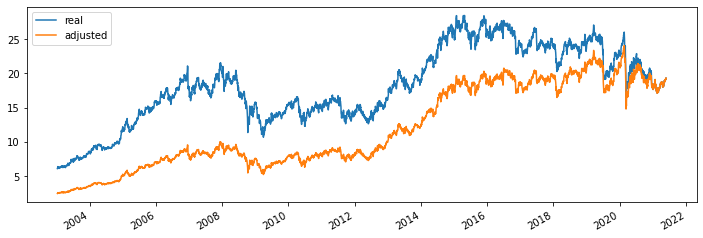

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
stock_prices.plot(ax=ax)

___
Obervamos que la fecha de pago es entre 2 y 4 sesiones posteriores a la fecha ex-dividendo. Aquí tenemos que considerar que:
 - Desde el punto de vista teórico, la serie ajustada puede reproducirse asumiendo el pequeños coste de financiar la compra el día del ex-dividendo. Esto es por ejemplo.
    - El día ex-dividendo se pide prestado el importe que recibirá el día de pago y se compran las acciones que se puedan a precio de ese día 
    - El día de pago se cobra el dividendo y se devuelve el prestamo
 - Desde un punto de vista práctico,  esto no es ejecutable sin una cuenta margen, por lo que tenemos que responder a la pregunta ¿**Cuánto coste implicito representa reinvertir los dividendo el día de pago**? 

___

- Hacemos la simulación de invertir inicialmente 100mil euros.
- Permitiremos invertir en fracciones de acciones para solo simular el efecto de comprar a precio distinto del ex-date

In [7]:
capital = 100_000

In [8]:
delta_shares = pd.Series(np.zeros(stock_prices.shape[0]), index=stock_prices.index)
init_shares  = capital/stock_prices.real.iloc[0]
delta_shares.iloc[0] = init_shares

In [9]:
positions = delta_shares.cumsum()
positions.head()

2003-01-10    16447.368421
2003-01-13    16447.368421
2003-01-14    16447.368421
2003-01-15    16447.368421
2003-01-16    16447.368421
dtype: float64

In [10]:
portvalue = positions * stock_prices.real

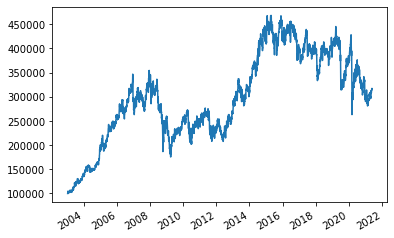

In [11]:
portvalue.plot()

In [13]:
delta_shares = pd.Series(np.zeros(stock_prices.shape[0]), index=stock_prices.index)
init_shares  = capital/stock_prices.real.iloc[0]
delta_shares.iloc[0] = init_shares
positions = delta_shares.cumsum()

for i, div_row in stock_divs.iterrows():
    pay_date = div_row['payment_date']
    ex_date = div_row['exdividend']
    curr_shares = positions.loc[ex_date]
    cash_div = curr_shares * div_row['dividend']
    
    new_shares = cash_div/stock_prices.real[pay_date]
    deserve_shares = cash_div/stock_prices.real[ex_date]
    delta_shares.loc[pay_date] = new_shares
    positions = delta_shares.cumsum()
    print(np.round(curr_shares, 2), cash_div, np.round(new_shares,2), np.round(deserve_shares, 2))

16447.37 1480.2631578947367 237.6 232.38
16684.97 2344.7389541268894 334.01 314.73
17018.98 2042.2775102550377 248.45 237.2
17267.43 3063.9330460664173 343.11 338.93
17610.54 2289.369824071709 198.56 196.01
17809.09 3582.7446400760023 249.84 247.94
18058.94 2889.4299985719003 187.26 182.76
18246.2 4378.065738290128 262.16 259.21
18508.36 3516.5879530176676 212.48 210.32
18720.84 5275.701285013752 292.61 287.5
19013.45 4563.227313840963 222.6 234.25
19236.04 6903.315909233228 409.94 383.52
19645.98 5107.954597044378 334.95 325.14
19980.93 7805.3693283605635 581.41 559.73
20562.33 5819.140125345436 382.21 379.1
20944.54 9760.722135420772 793.23 787.79
21737.77 6782.185588926173 443.86 444.44
22181.63 11670.26816006591 727.57 698.4
22909.21 8728.40804409909 637.58 628.17
23546.78 14406.157261090893 1049.25 994.56
24596.03 10527.100681507676 643.86 647.22
25239.89 17283.468309786746 944.19 910.37
26184.08 13170.593669695649 708.48 691.55
26892.56 20535.885051034333 923.58 873.87
27816.14 1

In [14]:
delta_shares[delta_shares != 0]

2003-01-10    16447.368421
2003-01-17      237.602433
2003-07-03      334.008398
2004-01-08      248.452252
2004-07-07      343.105604
2005-01-12      198.557660
2005-07-04      249.842722
2006-01-12      187.260531
2006-07-06      262.159625
2007-01-11      212.482656
2007-07-05      292.606838
2008-01-10      222.596454
2008-07-03      409.935624
2009-01-12      334.947842
2009-07-02      581.405537
2009-12-22      382.209532
2010-07-05      793.232193
2010-12-21      443.860313
2011-07-05      727.572828
2011-12-21      637.575460
2012-07-05     1049.246705
2012-12-20      643.859369
2013-07-03      944.193844
2013-12-19      708.477336
2014-07-03      923.583767
2014-12-19      558.470844
2015-07-02      908.546779
2015-12-17      567.082681
2016-07-05      861.880913
2016-12-22      706.347119
2017-07-05     1110.296859
2017-12-21      789.887783
2018-07-05     1200.129254
2018-12-19      857.018140
2019-07-03     1381.326600
2019-12-23     1012.244569
2020-07-09     1739.021605
2

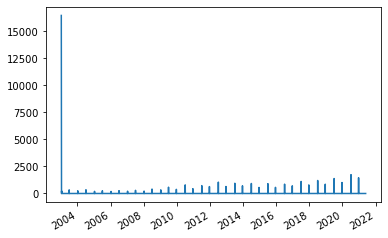

In [15]:
delta_shares.plot()

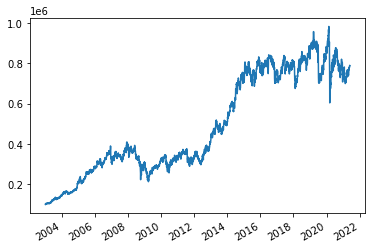

In [16]:
portvalue = positions * stock_prices.real
portvalue.plot()

In [17]:
relative_port = portvalue/portvalue.iloc[0]
relative_adjusted = stock_prices.adjusted/stock_prices.adjusted.iloc[0]

In [18]:
relative_adjusted

2003-01-10    1.000000
2003-01-13    1.021538
2003-01-14    1.052308
2003-01-15    1.027692
2003-01-16    1.033846
                ...   
2021-05-24    7.833605
2021-05-25    7.856180
2021-05-26    7.921853
2021-05-27    7.882860
2021-05-28    7.909539
Name: adjusted, Length: 4684, dtype: float64

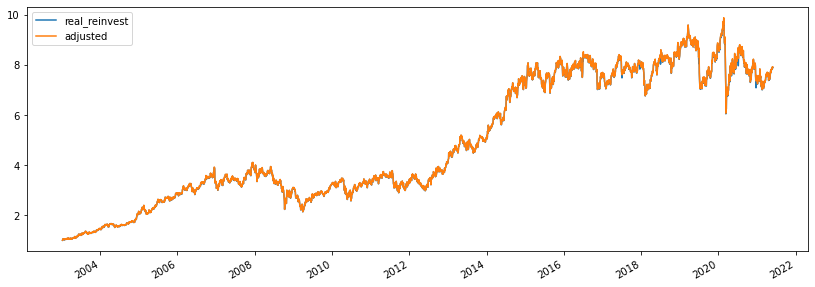

In [19]:
df_compare = pd.concat([relative_port, relative_adjusted], axis=1)
df_compare.columns = ['real_reinvest','adjusted']
df_compare.plot(figsize=(14,5))

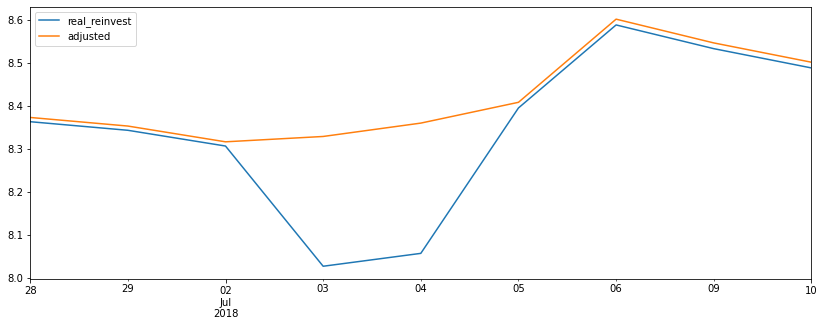

In [20]:
df_compare.loc['2018-06-28':'2018-07-10'].plot(figsize=(14,5))

In [21]:
df_compare.tail()

,real_reinvest,adjusted
2021-05-24,7.817593,7.833605
2021-05-25,7.840122,7.856180
2021-05-26,7.905662,7.921853
2021-05-27,7.866748,7.882860
2021-05-28,7.893373,7.909539
